# Триангуляция

In [139]:
import warnings
from scipy.spatial import Delaunay
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from scipy.spatial import ConvexHull, convex_hull_plot_2d
warnings.filterwarnings('ignore')

In [140]:
# созадние точек
width = 100
height = 100
pointNumber = 10
points = np.zeros((pointNumber, 2)) 
points[:, 0] = np.random.randint(-width, width, pointNumber)/100 
points[:, 1] = np.random.randint(-height, height, pointNumber)/100
points[0,0] = 0
points[0,1] = 0

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

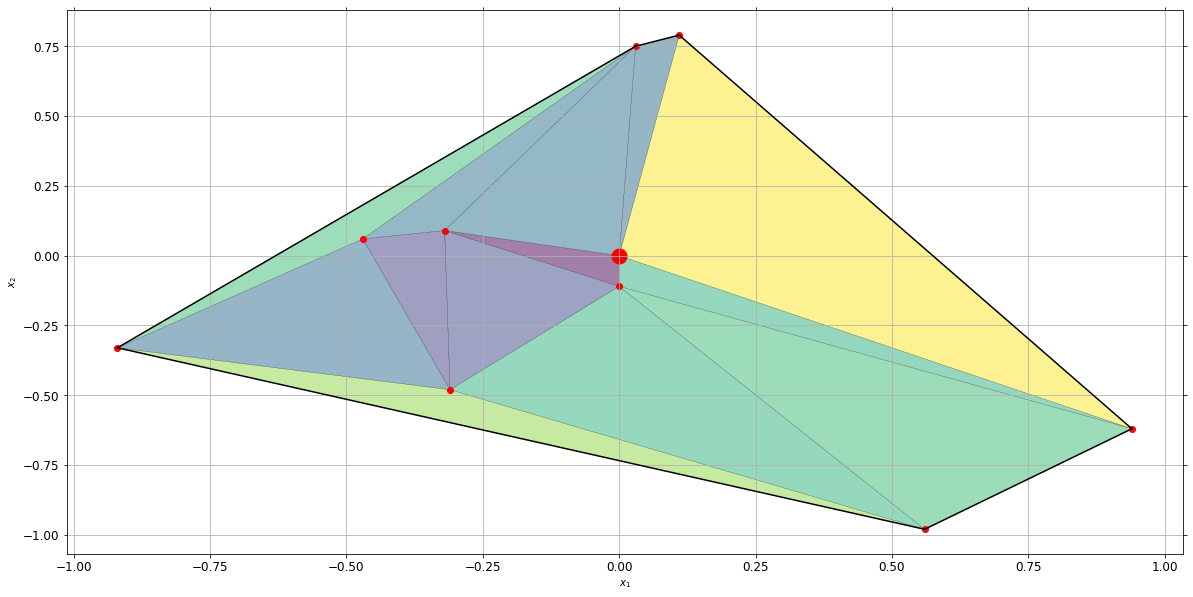

In [141]:

tri = Delaunay(points)
center = np.sum(points[tri.simplices], axis=1)/3.0 

color = []
for index, sim in enumerate(points[tri.simplices]):
    cx, cy = center[index][0], center[index][1]
    x1, y1 = sim[0][0], sim[0][1]
    x2, y2 = sim[1][0], sim[1][1]
    x3, y3 = sim[2][0], sim[2][1]
    
    s = ((x1-cx)**2+(y1-cy)**2)**0.5 + ((cx-x3)**2+(cy-y3)**2)**0.5 + ((cx-x2)**2+(cy-y2)**2)**0.5
    color.append(s)
color = np.array(color) / np.max(color)
color_sz = len(color)

plt.figure(figsize=(20, 10)) 
plt.tripcolor(points[:, 0], points[:, 1], tri.simplices.copy(), facecolors=color, edgecolors='k',alpha=0.5) 

plt.tick_params(labelbottom='off', labelleft='off', left='off', right='off', bottom='off', top='off') 
ax = plt.gca() 
plt.scatter(points[:,0],points[:,1], color='r')
plt.scatter(points[0,0],points[0,1], color='r', linewidths= 10)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

#выпуклая оболчка
hull = ConvexHull(points)
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

boundary_vertex = np.unique(np.reshape(hull.simplices,[-1])) # граничные вершины
    
plt.grid()
#plt.show()
plt.savefig('destination_path.eps', format='eps')

#plt.savefig('Delaunay_1.png', transparent=True, dpi=600)

# Задание параметров модели

In [142]:
R = np.array([[1, 1], [-1, 1], [1, -1], [-1, -1]])/100 # погрешность находиться в выпуклой оболочке точек
P = np.array([[1, 0], [0, 1], [-1, 0], [0,-1]]) # ограничение на матрицу управления
p = np.array([1, 1, 1, 1]) # ограничение на матрицу управления
C = np.array([[1, 0], [0, 1]]) # матрица -- связь погрешности и реальных координат

dim = 2 # размерность пространства
vertex_R_sz = len(R) # количество вершин R
m = len(P) # количество ограничений на управления
sym_num = len(tri.simplices)
def f_func(x): # сделать многомерный вход
    return 0.1*x
def g_func(x): # сделать многомерный вход переделать
    dim = 2
    ans = []
    for i in range(x.shape[1]):
        ans.append(np.eye(dim))
    return np.array(ans)
def calc_S(H_curr, B_curr, K, R):
    res = 0
    for i in range(len(R)):
        S_curr = H_curr @ B_curr @ K @ R[i]
        if res < np.abs(np.max(S_curr)):
            res = np.abs(np.max(S_curr))
    return res

# Шаг 1(поиск матрицы управления $K$)

$$\dot x = f(x) + g(x)u$$


$$P_s^TK(Cg+\eta) \le p_s, \; \forall s=1,...,m, \; \forall g \mbox{ -- вершина }\Omega^{(i)}, \; \forall \eta \mbox{ -- вершина } \mathcal{R} .$$


In [143]:
# делаем матрицу(коффициентов) для симплекса (i) = num_sim в неравествах для задачи линейного програмирования
linprog_coff = []
linprog_vec = []
for i in range(m): # для всех ограничений
    P_s_T = np.reshape(P[i],[dim,1])
    for j in range(pointNumber): # для любой вершины \OMEGA # j range dim+1
        for k in range(vertex_R_sz): # для любой вершины \R
            g = points[j]#g = points[tri.simplices[num_sim]][j]
            eta = R[k]
            s = np.reshape(C @ g + eta, [1, dim])
            p_vec = np.reshape(P[i], [dim,1])
            coff = np.reshape(p_vec @ s, [1,-1])[0]
            linprog_coff.append(coff)
            linprog_vec.append(p[i])
linprog_coff = np.array(linprog_coff)
linprog_vec = np.array(linprog_vec)

In [144]:
res = linprog(-np.ones(dim*dim), A_ub=linprog_coff, b_ub=linprog_vec) # любая а стоят K[i][j] > 0

In [145]:
# Проверка на K
#P[0].T @ K @ (C @ points[tri.simplices[5][2]] + R[1])

In [146]:
K = np.reshape(res.x,[dim,dim]) # матрица управления

In [147]:
print(K)

[[0.65415245 1.15187713]
 [0.65415245 1.15187713]]


# Шаг 2 (определение параметров системы)


In [148]:
A = [] # соответсвует i - му симплексу
B = []
G = [] # +
S = []
H = [] # +
h = [] # +
f = []
for i in range(sym_num):
    sym = tri.simplices[i]
    G_tilde = np.concatenate((points[sym], np.ones([3,1])),axis = 1).T
    G_inv = np.linalg.inv(G_tilde)
    
    h_curr = G_inv[: ,dim:dim+1]
    F_curr = f_func(points[sym].T)# Cделать многомерный вход
    H_curr = G_inv[: ,0:dim]
    A_curr = F_curr @ H_curr
    B_curr = np.sum(g_func(points[sym].T), axis = 0)/(dim+1)
    S_curr = calc_S(H_curr, B_curr, K, R)
    f_curr = F_curr @ h_curr
    
    S.append(S_curr)
    B.append(B_curr)
    G.append(G_tilde)
    A.append(A_curr)
    H.append(H_curr)
    h.append(h_curr)
    f.append(f_curr)

A = np.array(A)
B = np.array(B)
G = np.array(G)
S = np.array(S)
H = np.array(H)
h = np.array(h)
f = np.array(f)
    

In [149]:
F = f_func(points[sym]) 
q1 = np.concatenate((points[sym], np.ones([3,1])),axis = 1).T


In [150]:
S

array([0.04989524, 0.22044946, 0.04494376, 0.27247642, 0.04920599,
       0.05415438, 0.26679982, 0.14734507, 0.05806525, 0.06326205,
       0.02970958, 0.22114648, 0.05357813])

# Шаг 3 (Оптимизация по K и v)








# Оптимизация по параметрам

In [151]:
def optimize_v(tri, sym_num, pointNumber, boundary_vertex, points, A, B, C, H, S, K, f):
    val_bound = 1
    eps = 0.01
    dim = 2
    
    Coff_linprog = np.zeros(pointNumber)
    v = []
    A_eq = []
    b_eq = []
    A_ub = []
    b_ub = []
    # условия типа равенство добавляем
    # на нулевую
    A_vec_eq = np.zeros(pointNumber)
    A_vec_eq[0] = 1
    A_eq.append(A_vec_eq)
    b_eq.append(0)

    # на граничные
    #sz_boundary_vertex = len(boundary_vertex)
    for qqq in boundary_vertex:
        A_vec_eq = np.zeros(pointNumber)
        A_vec_eq[qqq] = 1
        A_eq.append(A_vec_eq)
        b_eq.append(1)

    #основной цикл

    for i in range(sym_num):

        sym = tri.simplices[i]


        # условия типа неравенства и кофф задачи
        for j in range(dim + 1):
            #
            Coff_C = (H[i] @ (A[i] @ points[sym[j]] + B[i] @ K @ C @ points[sym[j]] + f[i].T[0]) )[j] + S[i] # тут была С
            Coff_linprog[sym[j]] = Coff_linprog[sym[j]]+Coff_C
            # вычисление коффициаентов неравенств
            if (sym[j] == 0):
                # нулевая вершина
                A_vec_eq = np.zeros(pointNumber)
                A_vec_eq[sym[j]] = 1
                #A_eq.append(A_vec_eq)
                #b_eq.append(0)
            else:
                # ненулевая вершина
                A_vec_ub = np.zeros(pointNumber)
                A_vec_ub[sym[j]] = -1
                b_ub.append(-eps)
                A_ub.append(A_vec_ub)

            if (np.argwhere(boundary_vertex == sym[j]).size == 0):
                # Внутренная
                # проверка на то что симплекс граничный 
                if (not (np.intersect1d(boundary_vertex, sym).size == 0) ):
                    # граничный симплекс
                    A_vec_ub = np.zeros(pointNumber)
                    A_vec_ub[sym[j]] = 1
                    b_ub.append(1-eps)
                    A_ub.append(A_vec_ub)
            else:
                # граничная
                A_vec_eq = np.zeros(pointNumber)
                A_vec_eq[sym[j]] = 1
                #A_eq.append(A_vec_eq)
                #b_eq.append(val_bound)

    A_eq = np.array(A_eq)
    b_eq = np.array(b_eq)
    A_ub = np.array(A_ub)
    b_ub = np.array(b_ub)
    #Coff_linprog
    new_v = linprog(Coff_linprog,A_eq = A_eq, b_eq = b_eq,  A_ub = A_ub, b_ub=b_ub, ) # любая а стоят K[i][j] > 0
    print(new_v.fun)
    return new_v.x  
            

In [152]:
def optimize_K(tri, sym_num, pointNumber, boundary_vertex, points, A, B, C, H, S, v):
    dim = 2
    Coff_linprog = np.zeros(dim * dim)
    #основной цикл
    for i in range(sym_num):
        sym = tri.simplices[i]
        # условия типа неравенства и кофф задачи
        for j in range(dim + 1):        
            s = np.reshape(C @ points[sym[j]] , [1, dim])

            p_vec = np.reshape(v[tri.simplices[i]] @ H[i] @ B[i], [dim,1])

            coff = np.reshape(p_vec @ s, [1,-1])[0]

            Coff_linprog = Coff_linprog + coff
    
    
    x0_bounds = (None, None)
    res = linprog(Coff_linprog, A_ub=linprog_coff, b_ub=linprog_vec, bounds=[x0_bounds, x0_bounds,x0_bounds,x0_bounds]) # любая а стоят K[i][j] > 0
    new_K=(res.x).reshape([2,2])
    print(res.fun)

    return new_K

In [153]:
new_v = optimize_v(tri, sym_num, pointNumber, boundary_vertex, points, A, B, C, H, S, K, f)
v = new_v
for i in range(4):
    new_K = optimize_K(tri, sym_num, pointNumber, boundary_vertex, points, A, B, C, H, S, v)
    K = new_K
    new_v = optimize_v(tri, sym_num, pointNumber, boundary_vertex, points, A, B, C, H, S, K,f)
    v = new_v


24.356328209179637
-18.134305056397977
-20.292887433242903
-46.00678337127849
-28.147376418861874
-46.00678337127849
-28.147376418861874
-46.00678337127849
-28.147376418861874


# Шаг 4(графики траекторий)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

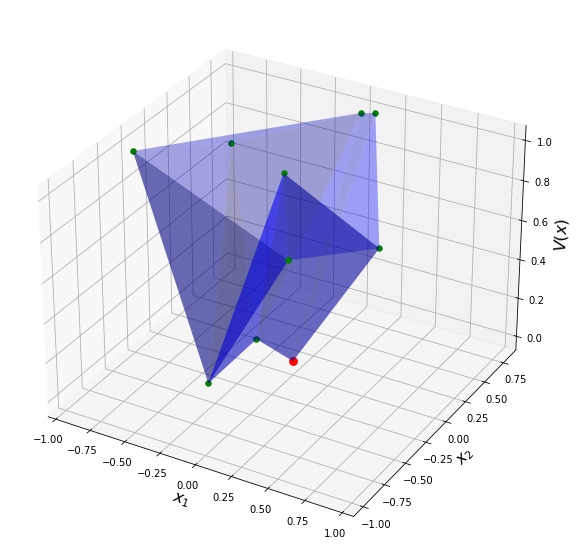

In [154]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import figure
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
fig, ax = plt.subplots(subplot_kw = dict(projection="3d"), figsize=(10,10))

for i in range(sym_num):
    sym = tri.simplices[i]
    # условия типа неравенства и кофф задачи
    triang = mtri.Triangulation((points[sym])[:,0], (points[sym])[:,1], triangles=[[0,1,2]])
    z = v[sym]
    if i == 0:
        ax.plot_trisurf(triang, z, color = 'b', alpha = 0.35, label='$V(x)$')
    else:
        ax.plot_trisurf(triang, z, color = 'b', alpha = 0.35)
        
ax.scatter([0], [0], zs=0, zdir='z',color='red', s=60)
for i in range(pointNumber):
    if i > 0:
        ax.scatter(points[i][0], points[i][1], zs=v[i], zdir='z',color='g', s=30)
ax.set_xlabel('$x_1$', fontsize=16)
ax.set_ylabel('$x_2$', fontsize=16)
ax.set_zlabel('$V(x)$', fontsize=16)

fig.show()
plt.savefig('func_2.eps', format='eps')


In [155]:
v

array([0.  , 0.01, 0.99, 1.  , 1.  , 0.01, 0.99, 1.  , 1.  , 1.  ])

In [156]:
K

array([[-1.06705605, -0.02246434],
       [-0.34001432, -1.19899785]])

In [157]:
sym_num

13

$$\dot x = f(x) + g(x)K(Cx+ \xi)$$
$$x_0 = [-0.6,0.75]$$
$$ |\xi| < 0.01$$

# Построение траектории

In [158]:
def xi_x(x):
    return np.array([np.sin(x[0]), np.cos(x[1])])*0.01

In [159]:
x_0 = np.array([0.3, 0.1])

In [160]:
from scipy.integrate import ode

In [161]:
y0, t0 = x_0, 0

In [162]:
def f(t, y):
    return y/10+np.array([[1,0],[0,1]]) @ K @ (C @ y+ xi_x(y))#y+np.array([[1,1],[1,1]]) @ K @ (C @ y+ xi_x(y))

In [163]:
f(0, np.array([0,0]))

array([-0.00022464, -0.01198998])

In [164]:
r = ode(f).set_integrator('zvode', method='bdf')

In [165]:
r.set_initial_value(y0, t0)

In [166]:
t1 = 10
dt = 0.01
tr_x = []
tr_y = []
tr_t = []
tr_x.append(y0[0])
tr_y.append(y0[1])
tr_t.append(0)
while r.successful() and r.t < t1:
    #print(np.abs(r.integrate(r.t+dt)[0]))
    #print(r.t+dt, r.integrate(r.t+dt))
    tr_x.append(r.integrate(r.t+dt)[0])
    tr_y.append(r.integrate(r.t+dt)[1])
    tr_t.append(r.t+dt)

In [167]:
tr_x = np.array(tr_x)
tr_y = np.array(tr_y)
tr_t = np.array(tr_t)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


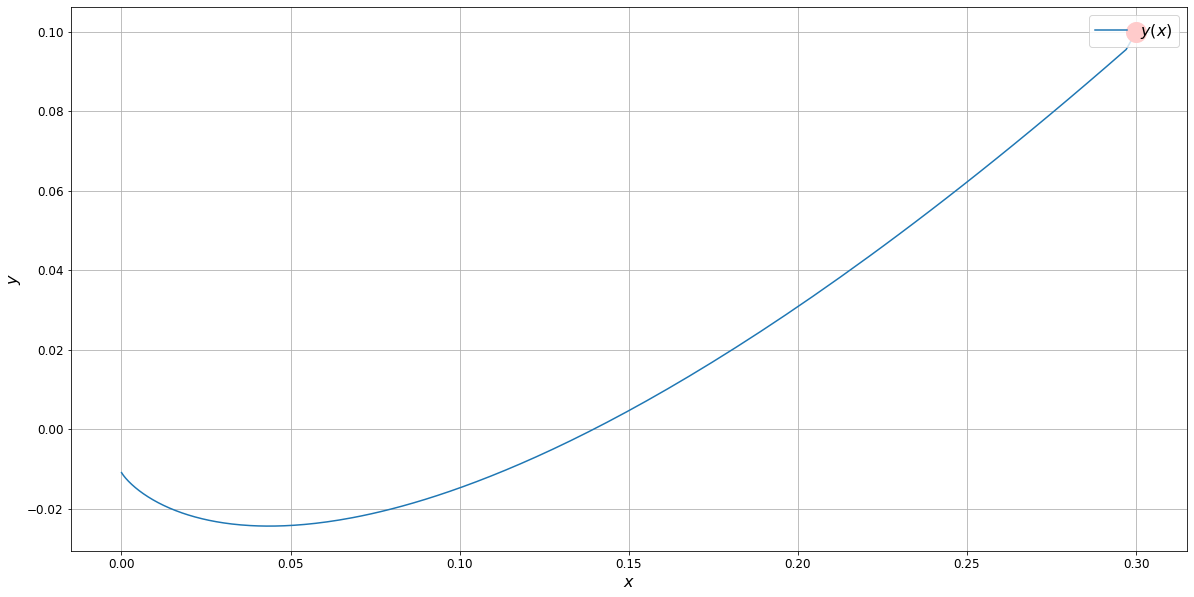

In [168]:
plt.figure(figsize=(20, 10))
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.grid(True)

plt.plot(tr_x, tr_y)
plt.plot(y0[0], y0[1], marker="o", markersize=20, markeredgecolor="red", markerfacecolor="red")
plt.xlabel('$x$',fontsize=16)
plt.ylabel('$y$',fontsize=16)
plt.legend(['$y(x)$'], loc='upper right',fontsize=16)
#plt.show()
plt.savefig('traectory.eps', format='eps')


In [169]:
y0

array([0.3, 0.1])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


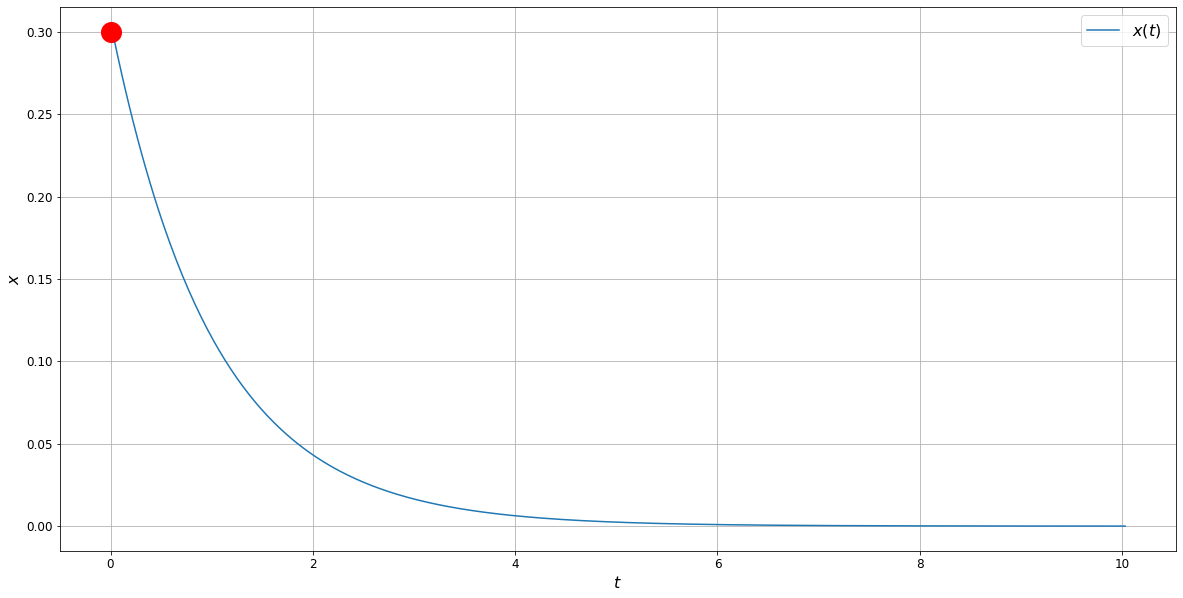

In [170]:
plt.figure(figsize=(20, 10))
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.grid(True)

plt.plot(tr_t, tr_x)
plt.plot(0, y0[0], marker="o", markersize=20, markeredgecolor="red", markerfacecolor="red")
plt.xlabel('$t$',fontsize=16)
plt.ylabel('$x$',fontsize=16)
plt.legend(['$x(t)$'], loc='upper right',fontsize=16)
#plt.show()
plt.savefig('traectory_x.eps', format='eps')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


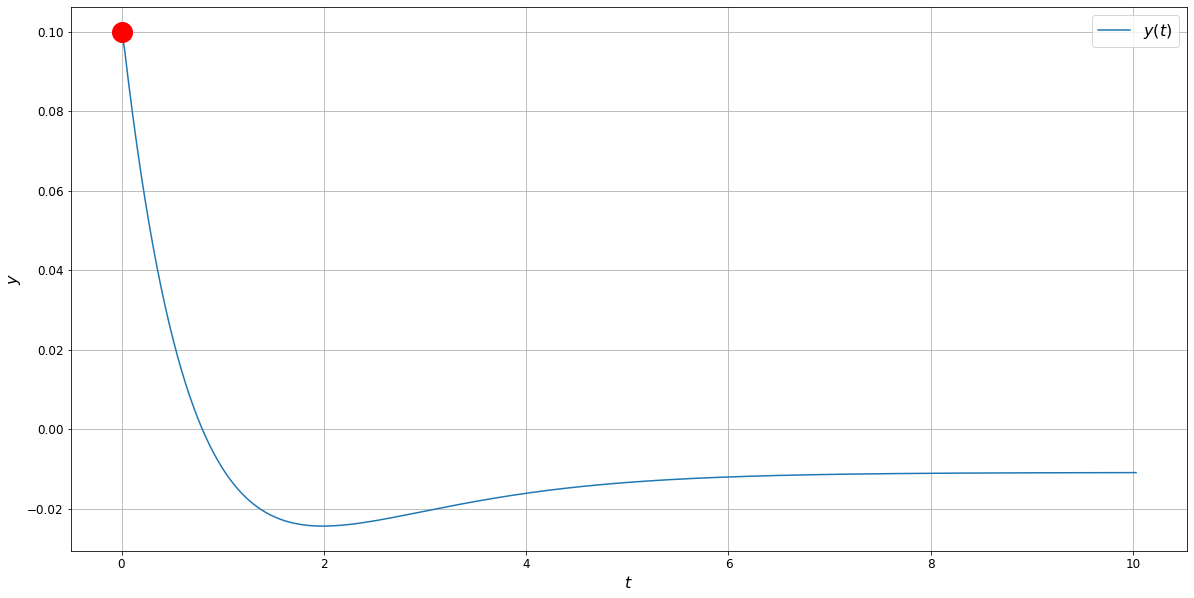

In [171]:
plt.figure(figsize=(20, 10))
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.grid(True)

plt.plot(tr_t, tr_y)
plt.plot(0, y0[1], marker="o", markersize=20, markeredgecolor="red", markerfacecolor="red")
plt.xlabel('$t$',fontsize=16)
plt.ylabel('$y$',fontsize=16)
plt.legend(['$y(t)$'], loc='upper right',fontsize=16)
#plt.show()
plt.savefig('traectory_y.eps', format='eps')
